# Import Data

In [1]:
PROJECT_PATH = "/Users/donghur/Desktop/Research/Murthy/AIcrowd_etho"
PROJECT_PATH_BMGPU = "/Users/donghur/Desktop/Research/Murthy/BM_GPU"

In [2]:
import sys, os, random, matplotlib, pickle, yaml, hdbscan
import numpy as np
from sklearn.utils import shuffle
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from glob2 import glob

sys.path.append(PROJECT_PATH)
sys.path.append(PROJECT_PATH_BMGPU)

from utils.data import Dataset

%load_ext autoreload
%autoreload 1
%aimport utils.data

In [10]:
config_path = f"{PROJECT_PATH_BMGPU}/config_aicrowd.yaml"
Data = Dataset(PROJECT_PATH, 'task1_etho', config_path)
Data.load_data()

Loading INFO.yaml ...
Finished loading INFO
Loading config.yaml ...


  1%|          | 1/140 [00:00<00:14,  9.30it/s]

Finished loading config


100%|██████████| 140/140 [00:17<00:00,  7.85it/s]


In [11]:
# configuration
INFO = Data.info
INFO_values = Data.info_values
config = Data.config
skeleton = config['skeleton']
skeleton_color= config['skeleton_color']

# features
bp = Data.data_obj['bodypoints']
rot_bp = Data.data_obj['rotated_bodypoints']
angles = Data.data_obj['angles']
limbs = Data.data_obj['limbs']
angle_power = Data.data_obj['angle_power']
limb_power = Data.data_obj['limb_power']

# embeddings
all_embed = Data.data_obj['all_embeddings']
all_postural_embed = Data.data_obj['all_postural_embeddings']
all_kinematic_embed = Data.data_obj['all_kinematic_embeddings']

In [5]:
norm_limbs = limbs/np.max(limbs, axis=0)
norm_limbs.shape

(1015476, 4)

# Angle Analysis

In [6]:
from helper import morlet

%load_ext autoreload
%autoreload 1
%aimport helper

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[ 0.3         0.36858761  0.45285608  0.55639046  0.68359543  0.83988268
  1.03190115  1.26781992  1.5576757   1.91379987  2.35134304  2.88891968
  3.54939997  4.36088281  5.35789119  6.58284097  8.08784533  9.93693185
 12.20876643 15.        ]
0.5


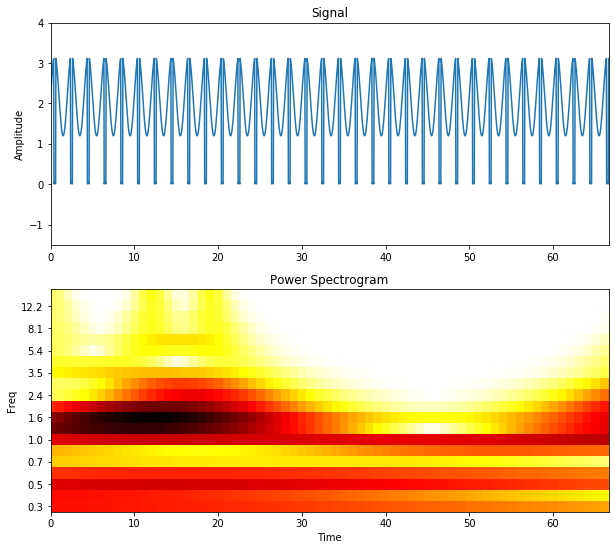

In [10]:
x_domain = np.arange(0,2000)
time = x_domain/config['fps']

max_freq, min_freq = config['fps']/2, config['f_min']# Nyquist Frequency
freq = max_freq*2**(-1*np.log2(max_freq/min_freq)*
    (np.arange(config['f_bin'],0,-1)-1)/(config['f_bin']-1))
print(freq)

# create signal
period = 2 # unit: sec
print(1/period)
test_wave = np.sin(2*np.pi*time/period)+2.2
# correct for out-bound pts
out_bound_idx = test_wave>np.pi
test_wave[out_bound_idx] = test_wave[out_bound_idx]-np.pi
# morlet
test_power = morlet(config, np.expand_dims(test_wave, axis=-1))


fig, ax = plt.subplots(2,1,figsize=(10,9))
ax[0].plot(time, test_wave)
ax[0].set(xlim=(0,time[-1]), ylabel="Amplitude", title="Signal",ylim=(-1.5,4))

ax[1].imshow(test_power[:,:,0].T, cmap='hot_r', aspect='auto', origin='lowest')
ax[1].set(
    title="Power Spectrogram",
    yticks=np.arange(len(freq))[::2], 
    yticklabels=np.round(freq,1)[::2],
    xlabel="Time",
    ylabel="Freq")

plt.xlim(0,time[-1])
plt.show()

[3.33333333 2.71305921 2.20820708 1.79729896 1.46285355 1.19064249
 0.96908507 0.78875555 0.64198215 0.52252068 0.42528886 0.34615016
 0.28173776 0.22931137 0.1866406  0.1519101  0.12364232 0.10063468
 0.08190836 0.06666667]


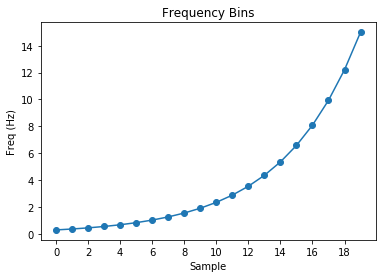

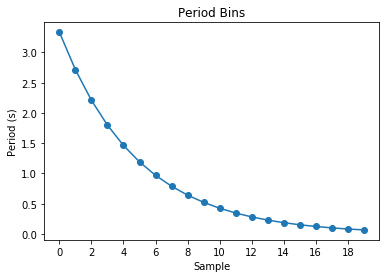

In [8]:
# plt.plot(freq)
print(1/freq)
plt.plot(freq,marker="o")
plt.xticks(np.arange(0,20,2))
plt.title("Frequency Bins")
plt.ylabel("Freq (Hz)")
plt.xlabel("Sample")
plt.show()

plt.plot(1/freq,marker="o")
plt.xticks(np.arange(0,20,2))
plt.title("Period Bins")
plt.ylabel("Period (s)")
plt.xlabel("Sample")
plt.show()

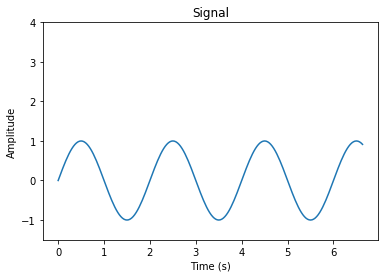

In [9]:
plt.plot(time[:200], test_wave[:200])
plt.title("Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.ylim(-1.5,4)
plt.show()

# Measuring Angle

In [190]:
data = np.array([[[1,1],[0,0],[1,0]],
                [[1,1],[0,0],[1,-1]],
                [[1,1],[0,0],[0,-1]],
                [[1,1],[0,0],[-1,-1]],
                [[1,1],[0,0],[-1,0]],
                [[1,1],[0,0],[-1,1]],
                [[1.5,1],[0,0],[-2,0.5]],
                [[-0.5,1.3],[0,0],[-1.5,-1.3]],
                [[0.5,1],[0,0],[-1.5,0.7]],
                [[-0.5,3],[-1,2],[-2.5,2.7]],
                [[-0.5,1],[0,0],[-2,0.1]],
                [[-1.5,-1.3],[0,0],[1.1,0.3]],
])

In [191]:
a = data[:,0,:]
b = data[:,1,:]
c = data[:,2,:]

ba = a - b
bc = c - b

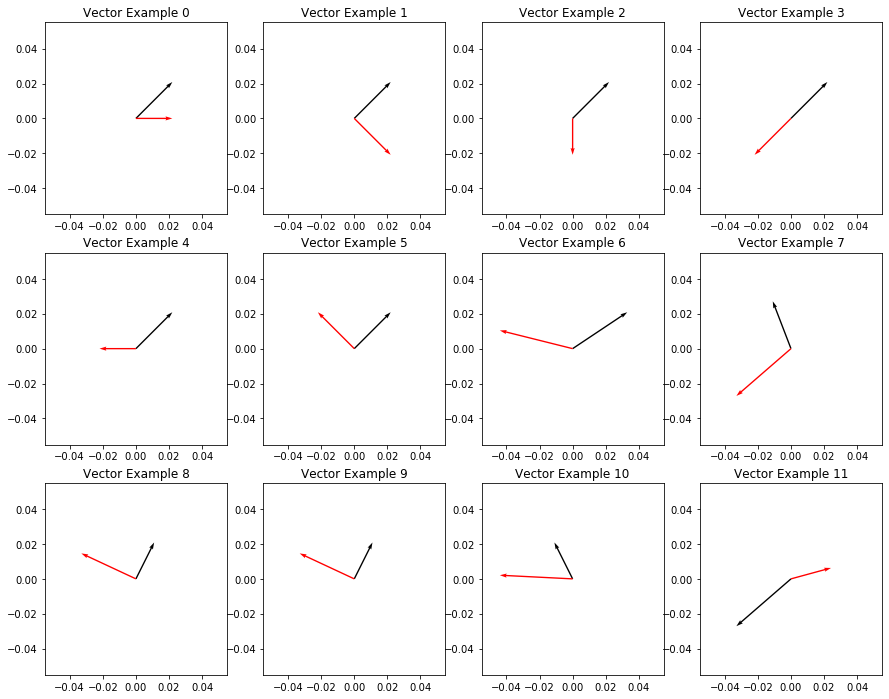

In [192]:
fig, ax = plt.subplots(3,4,figsize=(15,12))
for i, (ba_vec, bc_vec) in enumerate(zip(ba,bc)):
    ax[i//4,i%4].quiver(0,0, ba_vec[0], ba_vec[1], scale=5)
    ax[i//4,i%4].quiver(0,0, bc_vec[0], bc_vec[1], color='r', scale=5)
    ax[i//4,i%4].set(title=f"Vector Example {i}")
plt.show()

# Angle Measurement 1

In [242]:
ba_norm = ba / np.linalg.norm(ba,axis=1,keepdims=True)
bc_norm = bc / np.linalg.norm(bc,axis=1,keepdims=True)

ba_bc_dot = (ba_norm*bc_norm).sum(axis=1)
ba_bc_cross = bc_norm[:,0]*ba_norm[:,1]-bc_norm[:,1]*ba_norm[:,0]
ang_meas1 = np.arctan2(ba_bc_cross,ba_bc_dot)
for i, ang in enumerate(ang_meas1):
    print(f"Angle {i}: {round(ang,1)}")

Angle 0: 0.8
Angle 1: 1.6
Angle 2: 2.4
Angle 3: 3.1
Angle 4: -2.4
Angle 5: -1.6
Angle 6: -2.3
Angle 7: -1.9
Angle 8: -1.6
Angle 9: -1.6
Angle 10: -1.1
Angle 11: -2.7


In [253]:
from sklearn.preprocessing import MinMaxScaler

ang_meas1_reshape = ang_meas1.reshape(-1, 1)
scaler = MinMaxScaler()
scaler.partial_fit(ang_meas1_reshape)
scaled_ang_meas1 = scaler.transform(ang_meas1_reshape)

for i, ang in enumerate(scaled_ang_meas1[:,0]):
    print(f"Angle {i}: {round(ang,1)}")


Angle 0: 0.6
Angle 1: 0.7
Angle 2: 0.9
Angle 3: 1.0
Angle 4: 0.1
Angle 5: 0.2
Angle 6: 0.1
Angle 7: 0.1
Angle 8: 0.2
Angle 9: 0.2
Angle 10: 0.3
Angle 11: 0.0


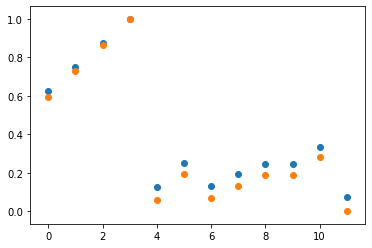

In [239]:
plt.scatter(np.arange(len(ang_meas1)),ang_meas1_test)
plt.scatter(np.arange(len(ang_meas1)),scaled_ang_meas1)
plt.show()

In [178]:
# DOES NOT WORK
# [-180,180]
# bc_xaxis_ang = np.arctan2(bc[:,1],bc[:,0])
# ba_xaxis_ang = np.arctan2(ba[:,1],ba[:,0])
# ang_meas1 = (ba_xaxis_ang-bc_xaxis_ang)*180/np.pi

# for i, ang in enumerate(ang_meas1):
#     print(f"Angle {i}: {round(ang,1)}")

# Angle Measurement 2

In [204]:
# [0,360]
ba_norm = ba / np.linalg.norm(ba,axis=1,keepdims=True)
bc_norm = bc / np.linalg.norm(bc,axis=1,keepdims=True)

ba_bc_dot = (ba_norm*bc_norm).sum(axis=1)
ba_bc_cross = bc_norm[:,0]*ba_norm[:,1]-bc_norm[:,1]*ba_norm[:,0]
ang_meas2 = np.arctan2(ba_bc_cross,ba_bc_dot)*180/np.pi
neg_idx = (np.sign(ang_meas2)==-1)
ang_meas2[neg_idx] += 360 

for i, ang in enumerate(ang_meas2):
    print(f"Angle {i}: {round(ang,1)}")

Angle 0: 45.0
Angle 1: 90.0
Angle 2: 135.0
Angle 3: 180.0
Angle 4: 225.0
Angle 5: 270.0
Angle 6: 227.7
Angle 7: 250.1
Angle 8: 268.5
Angle 9: 268.5
Angle 10: 299.4
Angle 11: 205.7


In [197]:
# DOES NOT WORK
# [0,360]
# bc_xaxis_ang = np.arctan2(-bc[:,1],-bc[:,0])
# ba_xaxis_ang = np.arctan2(ba[:,1],ba[:,0])
# ang_meas2 = (ba_xaxis_ang-bc_xaxis_ang)*180/np.pi+180

# for i, ang in enumerate(ang_meas2):
#     print(f"Angle {i}: {round(ang,1)}")

In [211]:
np.arctan2(np.nan, np.nan)

nan

# Scaling

In [14]:
test = np.array([[0,1],[1.5,1],[-2,1],[-1.4,1],[3.6,-1]])
test.shape

(5, 2)

In [18]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.partial_fit(test)

print(scaler.transform(test))

[[-0.16753851  0.5       ]
 [ 0.57160198  0.5       ]
 [-1.15305917  0.5       ]
 [-0.85740297  0.5       ]
 [ 1.60639868 -2.        ]]


In [19]:
import pickle

with open("test.pickle", 'wb') as file:
    pickle.dump(scaler, file)

In [23]:
with open ("test.pickle", 'rb') as file:
    scaler_pickle = pickle.load(file)

test2 = np.array([[10,1],[5,1],[-2,1],[-1.4,1],[3.6,-1]])
scaler_pickle.partial_fit(test2)

print(scaler_pickle.transform(test2))

[[ 2.24899541  0.5       ]
 [ 0.89580924  0.5       ]
 [-0.99865139  0.5       ]
 [-0.83626905  0.5       ]
 [ 0.51691712 -2.        ]]


In [24]:
print(scaler_pickle.transform(test2))
print(scaler_pickle.n_samples_seen_)

[[ 2.24899541  0.5       ]
 [ 0.89580924  0.5       ]
 [-0.99865139  0.5       ]
 [-0.83626905  0.5       ]
 [ 0.51691712 -2.        ]]
10


In [29]:
print(scaler_pickle.scale_)
print(scaler_pickle.mean_)
print(scaler_pickle.var_)

[3.69498309 0.8       ]
[1.69 0.6 ]
[13.6529  0.64  ]
